In [34]:
import numpy as np
import pandas as pd
from numpy.random import randn
from shapedtw.shapedtw import shape_dtw
from shapedtw.shapeDescriptors import SlopeDescriptor, PAADescriptor, CompoundDescriptor, DerivativeShapeDescriptor
from shapedtw.dtwPlot import dtwPlot
from matplotlib import pyplot as plt 

shape_dtw(x, y, subsequence_width: int,
              shape_descriptor: ShapeDescriptor,
              step_pattern: str = "symmetric2",
              dist_method: str ="euclidean",
              multivariate_version: str = "dependent",
              **kwargs)

#### Compare DTW and shapeDTW on OSUleaf dataset

In [28]:
from aeon.datasets import load_osuleaf
X_test, y_test = load_osuleaf(split="TEST")

In [30]:
X_test.shape

(242, 1, 427)

<function matplotlib.pyplot.show(close=None, block=None)>

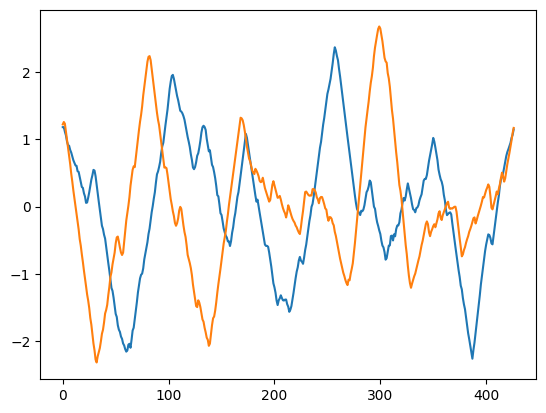

In [31]:
plt.plot(X_test[114][0])
plt.plot(X_test[134][0])
plt.show

In [32]:
# same ts as in the paper example
ts_x = X_test[114][0]
ts_y = X_test[134][0]

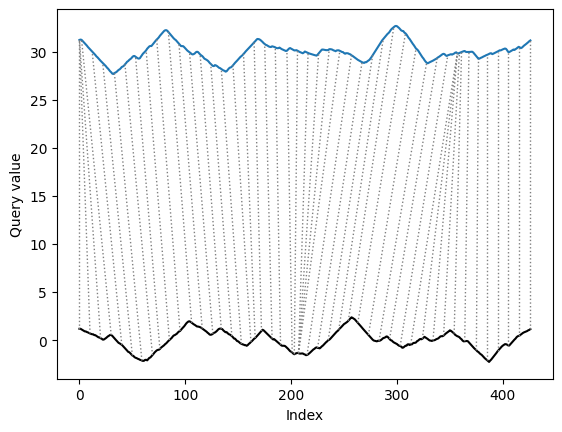

In [41]:
slope_descriptor = SlopeDescriptor(slope_window=5)
paa_descriptor = PAADescriptor(piecewise_aggregation_window=5)
compound_descriptor = CompoundDescriptor([slope_descriptor, paa_descriptor],descriptors_weights=[5., 1.])

shape_dtw_results = shape_dtw(
    x=ts_x,
    y=ts_y,
    subsequence_width=30,
    step_pattern="symmetric1",
    shape_descriptor=DerivativeShapeDescriptor()
)

dtwPlot(shape_dtw_results, plot_type="twoway", yoffset = 30)